In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Import train and test sets
train = pd.read_csv('../Data/training_set.csv', index_col = 0)
test = pd.read_csv('../Data/test_set.csv', index_col = 0)

In [3]:
train.head()

,Name,Age,Breed1,Breed2,Color1,Color2,Color3,MaturitySize,FurLength,Health,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
0,nibble,3,299,0,1,7,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,no name yet,1,265,0,1,2,0,2,2,1,...,0,0,0,0,0,0,0,0,1,0
2,brisco,1,307,0,2,7,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
3,miko,4,307,0,1,2,0,2,1,1,...,0,0,0,0,0,0,0,0,1,0
4,hunter,1,307,0,1,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 51 columns):
Name              14993 non-null object
Age               14993 non-null int64
Breed1            14993 non-null int64
Breed2            14993 non-null int64
Color1            14993 non-null int64
Color2            14993 non-null int64
Color3            14993 non-null int64
MaturitySize      14993 non-null int64
FurLength         14993 non-null int64
Health            14993 non-null int64
Quantity          14993 non-null int64
Fee               14993 non-null int64
RescuerID         14993 non-null object
VideoAmt          14993 non-null int64
Description       14981 non-null object
PetID             14993 non-null object
PhotoAmt          14993 non-null float64
AdoptionSpeed     14993 non-null int64
des_sent_mag      14993 non-null float64
des_sent_score    14993 non-null float64
named             14993 non-null int64
mixed_breed       14993 non-null int64
mixed_color       14993

In [5]:
test.head()

,Name,Age,Breed1,Breed2,Color1,Color2,Color3,MaturitySize,FurLength,Health,...,State_41327,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401
0,Puppy,2,307,0,1,0,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
1,London,24,266,0,2,7,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Snowball,20,266,0,7,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Malibu,5,266,252,1,6,7,2,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Lala Girl,6,307,0,1,2,7,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3948 entries, 0 to 3947
Data columns (total 49 columns):
Name              3948 non-null object
Age               3948 non-null int64
Breed1            3948 non-null int64
Breed2            3948 non-null int64
Color1            3948 non-null int64
Color2            3948 non-null int64
Color3            3948 non-null int64
MaturitySize      3948 non-null int64
FurLength         3948 non-null int64
Health            3948 non-null int64
Quantity          3948 non-null int64
Fee               3948 non-null int64
RescuerID         3948 non-null object
VideoAmt          3948 non-null int64
Description       3946 non-null object
PetID             3948 non-null object
PhotoAmt          3948 non-null float64
des_sent_mag      3948 non-null int64
des_sent_score    3948 non-null int64
named             3948 non-null int64
mixed_breed       3948 non-null int64
mixed_color       3948 non-null int64
Type_1            3948 non-null int64
Type_2       

In the *Feature_Engineering* notebook, new columns like ``named``, ``mixed_breed``, and ``mixed_color`` were added to simplify and condense multiple columns. Therefore the columns like ``Name``, ``Breed1``, ``Breed2``, etc. can be removed since they're correlated to each other.

In [7]:
# Create list of columns to be removed
remove_cols = ['Name', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Description']

In [8]:
# Remove columns from train and test sets
train_removed = train.drop(remove_cols, axis = 1)
test_removed = test.drop(remove_cols, axis = 1)

## A Brief Look at ``RescuerID``

Other columns like ``RescuerID`` and ``PetID`` should also be removed before further analysis since identifiers like these should be independent of how quickly a pet is adopted. However, ``RescuerID`` is interesting because some rescuers could be better at documenting pets than others, offering more insight and better descriptions of the pets they list. Quickly looking at the statistics of ``RescuerID`` could help determine if this column is relevant.

In [9]:
# Get count of the number of rescuers
train_rescuers = train_removed['RescuerID'].unique()

print('Number of unique rescuers in train: %d' % len(train_rescuers))

Number of unique rescuers in train: 5595


In [10]:
# Aggregate des_sent_mag and des_sent_score by RescuerID
rescuers = train_removed.groupby('RescuerID')['AdoptionSpeed', 'des_sent_mag', 'des_sent_score', 'PetID'].agg({'PetID':'count',
                                                                                                               'AdoptionSpeed':'mean',
                                                                                                               'des_sent_mag':'mean',
                                                                                                               'des_sent_score':'mean'})

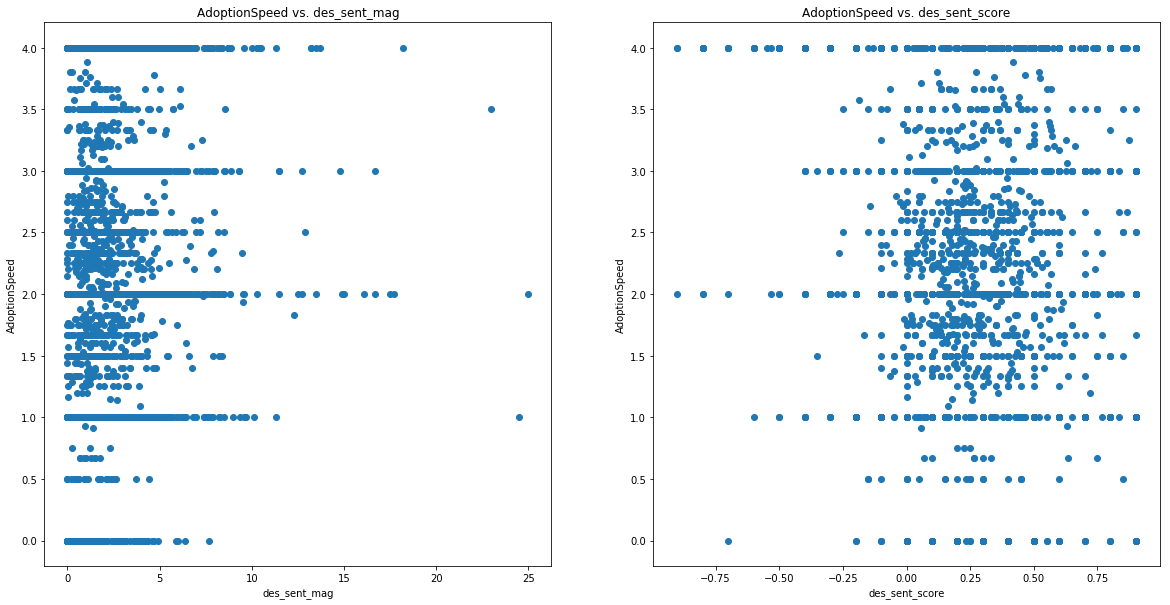

In [11]:
_ = plt.figure(figsize=(20, 10))
_ = plt.subplot(1, 2, 1)
_ = plt.scatter(rescuers['des_sent_mag'], rescuers['AdoptionSpeed'])
_ = plt.title('AdoptionSpeed vs. des_sent_mag')
_ = plt.xlabel('des_sent_mag')
_ = plt.ylabel('AdoptionSpeed')

_ = plt.subplot(1, 2, 2)
_ = plt.scatter(rescuers['des_sent_score'], rescuers['AdoptionSpeed'])
_ = plt.title('AdoptionSpeed vs. des_sent_score')
_ = plt.xlabel('des_sent_score')
_ = plt.ylabel('AdoptionSpeed')

In [12]:
rescuers.corr()

,PetID,AdoptionSpeed,des_sent_mag,des_sent_score
PetID,1.000000,-0.035519,-0.001816,-0.001247
AdoptionSpeed,-0.035519,1.000000,-0.044734,0.029720
des_sent_mag,-0.001816,-0.044734,1.000000,0.064016
des_sent_score,-0.001247,0.029720,0.064016,1.000000


Based on these plots and the correlation between ``AdoptionSpeed`` and the two description quantities, it doesn't seem to matter who posts the pets when it comes to ``AdoptionSpeed``. That means both ``RescuerID`` and ``PetID`` can be removed from the training and test sets.

In [13]:
# Remove RescuerID and PetID from train and test set
train_new = train_removed.drop(['RescuerID', 'PetID'], axis = 1)
test_new = test_removed.drop(['RescuerID', 'PetID'], axis = 1)

# Data Preprocessing

A few items need to be checked before moving on to modeling the data. The first is to check the distribution of values in the target variable. This will help determine if there's a class imbalance that needs to be handled.

In [14]:
# Obtain counts of AdoptionSpeed values
adoption_counts = train_new.groupby('AdoptionSpeed')['Age'].count()
adoption_counts

AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: Age, dtype: int64

Aside from ``AdoptionSpeed`` of $0$, the classes seem balanced for the most part. For the first iteration of the model, balancing the classes won't be necessary but is something to think about when building upon it.

Next is to split the data into a true training set and a validation set to evaluate our model.

In [15]:
# Separate feature and target variables from train_new
X, y = train_new.drop('AdoptionSpeed', axis = 1), train_new['AdoptionSpeed']

In [16]:
# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size = 0.3,
                                                 random_state = 456,
                                                 stratify = y)

# Machine Learning Algorithms

Now that the data is in a favorable format, the next step is to determine which model best suits the needs of the problem. Given that the problem is to predict how long a pet is expected to be adopted, broken into 5 distinct groups, a supervised classification algorithm is most suitable. Of the different algorithms, a random forest or XGBoost learner is recommended for its speed and accuracy for training the nearly 15,000 data points in this problem. An attempt creating a support vector machine (SVM) or k-nearest neighbors (kNN) model will be done but isn't advised due to their slow training speeds. A neural network would also be suitable if there were more observations in the data.

## Evaluation Metric

For a model to be valid, it has to be able to perform better than random guessing. In this multiclassification problem, that's better than the percentage of observations in the most common class.

In [17]:
# Calculate percentage of each class
adoption_counts/len(train_new)

AdoptionSpeed
0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: Age, dtype: float64

Here, an ``AdoptionSpeed`` of $4$ occurred the most at around $28%$ of the time so the model should have an accuracy *at least* this good to be considered. Below, I've pulled a function from a previous project of mine and modified it for this problem.

In [18]:
def model_metrics(model, val_features, val_labels):
    '''This function will print the metrics and scores of a model on test data'''
    
    # Make predictions on the test data
    predictions = model.predict(val_features)
    predictions_df = pd.DataFrame(predictions)
    
    # Print accuracy
    print(accuracy_score(val_labels, predictions))
    
    # Print classification report
    print(classification_report(val_labels, predictions))
    
    # Calculate AUC score
    # auc = roc_auc_score(val_labels, predictions_df)
    # print('AUC = %.2f' % auc)
    
    # Calculate confusion matrix
    cm = confusion_matrix(val_labels, predictions)
    cm_df = pd.DataFrame(cm)
    
    # Plot the confusion matrix
    _ = plt.figure(figsize=(10, 10))
    _ = sns.heatmap(cm_df, annot = True, fmt = 'd', cmap = 'coolwarm')
    _ = plt.title('Model Confusion Matrix')
    _ = plt.xlabel('Prediction Value')
    _ = plt.ylabel('True Value')

## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [27]:
# Define a parameter grid for GridSearchCV
rfc_n_estimators = [10, 50, 100, 150]
rfc_max_depth = [2, 5, 10, 15, 20]
rfc_min_samples_split = [2, 5, 10, 15]

rfc_param_grid = {'n_estimators':rfc_n_estimators,
                  'max_depth':rfc_max_depth,
                  'min_samples_split':rfc_min_samples_split}

In [28]:
# Instantiate RandomForestClassifier
rfc = RandomForestClassifier()

In [29]:
# Define GridSearchCV for RandomForestClassifier
rfc_cv = GridSearchCV(rfc, 
                      rfc_param_grid,
                      cv = 5,
                      scoring='accuracy',
                      n_jobs = 4,
                      verbose = 1)

In [30]:
# Fit rfc_cv to training data
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150], 'max_depth': [2, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [31]:
rfc_cv.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

0.4030680302356603
             precision    recall  f1-score   support

          0       1.00      0.04      0.08       123
          1       0.36      0.26      0.30       927
          2       0.34      0.41      0.38      1211
          3       0.40      0.21      0.27       978
          4       0.47      0.68      0.55      1259

avg / total       0.41      0.40      0.38      4498



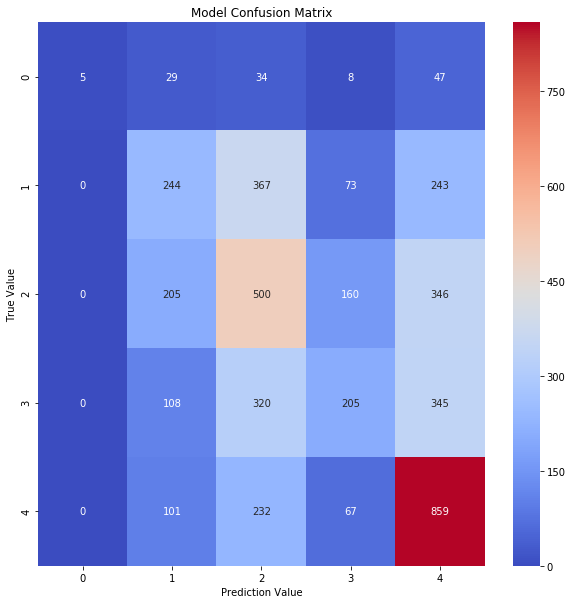

In [32]:
model_metrics(rfc_cv.best_estimator_, X_val, y_val)

In [33]:
# Refine grid parameters
rfc2_n_estimators = [i for i in range(80, 125, 5)]
rfc2_max_depth = [12, 15, 18]

rfc2_param_grid = {'n_estimators':rfc2_n_estimators,
                  'max_depth':rfc2_max_depth}

In [34]:
rfc2 = RandomForestClassifier()

In [35]:
rfc2_cv = GridSearchCV(rfc2,
                       rfc2_param_grid,
                       cv = 5,
                       scoring='accuracy',
                       n_jobs = 4,
                       verbose = 1)

In [36]:
rfc2_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [80, 85, 90, 95, 100, 105, 110, 115, 120], 'max_depth': [12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
rfc2_cv.best_params_

{'max_depth': 18, 'n_estimators': 95}

0.4077367718986216
             precision    recall  f1-score   support

          0       0.83      0.04      0.08       123
          1       0.35      0.29      0.32       927
          2       0.35      0.39      0.37      1211
          3       0.37      0.25      0.30       978
          4       0.49      0.67      0.56      1259

avg / total       0.41      0.41      0.39      4498



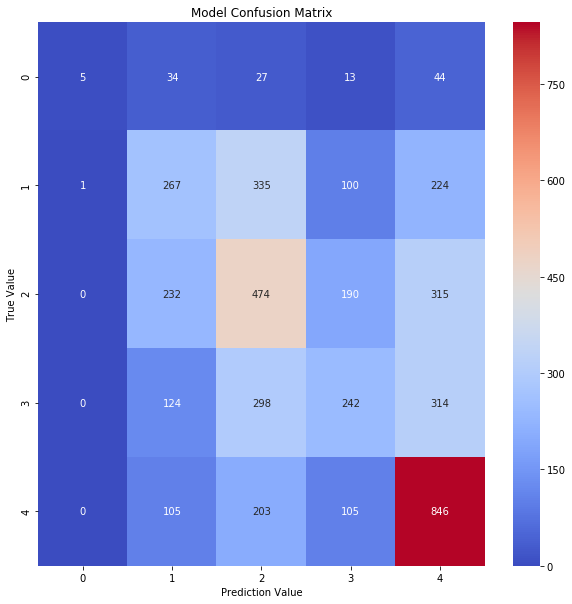

In [38]:
model_metrics(rfc2_cv.best_estimator_, X_val, y_val)

## XGBoost

In [19]:
from xgboost import XGBClassifier

In [22]:
# Define search grid 
xgb_max_depth = [i for i in range(5, 25, 5)]
xgb_learning_rate = [0.1, 0.01, 0.001]
xgb_n_estimators = [i for i in range(25, 175, 25)]
xgb_min_samples_split = [2, 5, 10, 15]

xgb_param_grid = {'max_depth':xgb_max_depth,
                 'learning_rate':xgb_learning_rate,
                 'n_estimators':xgb_n_estimators,
                 'min_samples_split':xgb_min_samples_split}

In [21]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

In [23]:
# Instantiate GridSearchCV
xgb_cv = GridSearchCV(xgb,
                      xgb_param_grid,
                      cv = 5,
                      scoring='accuracy',
                      n_jobs = 4,
                      verbose = 1)

In [24]:
xgb_cv.fit(X_train, y_train)

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chiga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py

KeyboardInterrupt: 

In [ ]:
xgb_cv.best_params_

In [ ]:
model_metrics(xgb_cv.best_estimator_, X_val, y_val)

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale X_train data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Transform X_val according to scaler
x_val_scaled = scaler.transform(X_val)

In [ ]:
# Apply PCA to X_train_scaled
pca = PCA(n_components = 2)        # or use float 0.95

# Fit-transform X_train_scaled
X_train_pca = pca.fit_trainsform(X_train_scaled)

# Transform X_val_scaled according to pca
X_val_pca = pca.transform(X_val_scaled)

In [ ]:
pca.explained_variance_ratio

In [ ]:
# Create kNN parameter grid
knn_n_neighbors = [5, 9, 13]

knn_param_grid = {'n_neighbors':knn_n_neighbors}

In [ ]:
# Instantiate kNN model
knn = KNeighborsClassifier()

In [ ]:
# Instantiate GridSearchCV model for kNN
knn_cv = GridsearchCV(knn,
                      knn_param_grid,
                      cv = 5,
                      scoring = 'accuracy',
                      n_jobs = 4,
                      verbose = 1)

In [ ]:
# Fit X_train_pca to knn_cv
knn_cv.fit(X_train_pca, y_train)

In [ ]:
knn_cv.best_params_

In [ ]:
model_metrics(knn_cv.best_estimator_, X_val_pca, y_val)